# Mail Spam Detection

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('spam.csv',encoding='latin1',usecols=['v1','v2'])

In [3]:
new_column_names = {'v1': 'Target', 'v2': 'Mail'}
df = data.rename(columns=new_column_names)


In [4]:
df.isna().sum()

Target    0
Mail      0
dtype: int64

## Text Processing

#### Removing Special Characters

In [5]:
import re

def remove_special_characters(text):
    # Remove special characters and punctuation
    clean_text = re.sub('[^A-Za-z\s]', '', text)
    return clean_text
df['Mail'] = df['Mail'].apply(remove_special_characters)

#### Removing Symbols

In [6]:
import re

def remove_symbols(text):
    # Remove symbols using regular expression
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    return cleaned_text
df['Mail'] = df['Mail'].apply(remove_symbols)

#### Removing Numeric digits

In [7]:
def remove_numeric(text):
    # Remove numeric values
    clean_text = re.sub(r'\d+', '', text)
    return clean_text
df['Mail'] = df['Mail'].apply(remove_numeric)

#### Converting to Lower Case

In [8]:
def convert_to_lowercase(text):
    # Convert text to lowercase
    lowercase_text = text.lower()
    return lowercase_text
df['Mail'] = df['Mail'].apply(convert_to_lowercase)

#### Lemmatization 

In [9]:
import nltk

# Specify the data path where NLTK should look for resources
nltk.data.path.append("/path/to/nltk_data")

# Download the "wordnet" resource
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in text.split()]
    return ' '.join(lemmatized_text)
df['Mail'] = df['Mail'].apply(lemmatize_text)

[nltk_data] Error loading wordnet: <urlopen error [WinError 10061] No
[nltk_data]     connection could be made because the target machine
[nltk_data]     actively refused it>


#### Removing Stop words

In [10]:
import nltk
from nltk.corpus import stopwords

def remove_stopwords(text):
    x = []
    for i in text.split():
        if i not in stopwords.words('english'):
            x.append(i)
    return x
df['Mail'] = df['Mail'].apply(remove_stopwords)

df.to_csv('cleaned.csv',index=False)

In [53]:
df2 = pd.read_csv('cleaned.csv')
df2['Mail'] = df2['Mail'].apply(remove_symbols)

<Axes: xlabel='Target', ylabel='count'>

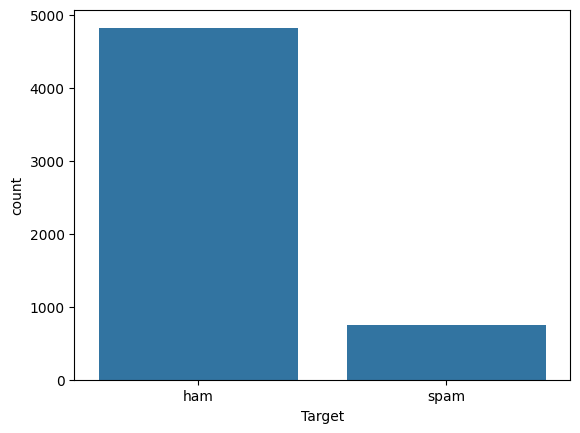

In [54]:
sns.barplot(df2['Target'].value_counts())

### Data Split

In [55]:
X = df2[['Mail']]
y = df2['Target']

In [56]:
X.shape,y.shape

((5572, 1), (5572,))

In [57]:
assert X.shape[0] == len(y)

In [58]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and temporary (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Split the temporary data into training (80%) and validation (20%)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42)

In [59]:
print(X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,X_test.shape,y_test.shape)

(3788, 1) (3788,) (669, 1) (669,) (1115, 1) (1115,)


### Vecotrizing the splits

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=1000)

X_train = cv.fit_transform(X_train['Mail']).toarray()
X_valid = cv.fit_transform(X_valid['Mail']).toarray()
X_test = cv.fit_transform(X_test['Mail']).toarray()

print(X_train.shape)
print('Vectorization complete')

(3788, 1000)
Vectorization complete


### Model Selection

In [73]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

In [74]:
def train_model(models, X_train, y_train,X_valid,y_valid):
    for model in models:
        model.fit(X_train,y_train)
        
        # Evaluate the model on the validation set
        accuracy = model.score(X_valid, y_valid)
        
        print(f'Accuracy % of {model.__class__.__name__}: {accuracy}')
        print('----------------------------------------------')


# Define the list of models
models = [GaussianNB(), MultinomialNB(), BernoulliNB()]

# Train and evaluate the models
train_model(models, X_train, y_train,X_valid,y_valid)

Accuracy % of GaussianNB: 0.6786248131539612
----------------------------------------------
Accuracy % of MultinomialNB: 0.7428998505231689
----------------------------------------------
Accuracy % of BernoulliNB: 0.8071748878923767
----------------------------------------------


### Model Tunning

In [75]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}
bernoulli_nb = BernoulliNB()
grid_search = GridSearchCV(bernoulli_nb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
print("Best Cross-Validation Score: {:.2f}".format(grid_search.best_score_))

Best Parameters:  {'alpha': 0.1}
Best Cross-Validation Score: 0.98


In [76]:
model = BernoulliNB(alpha=0.1)
model.fit(X_train,y_train)

BernoulliNB(alpha=0.1)

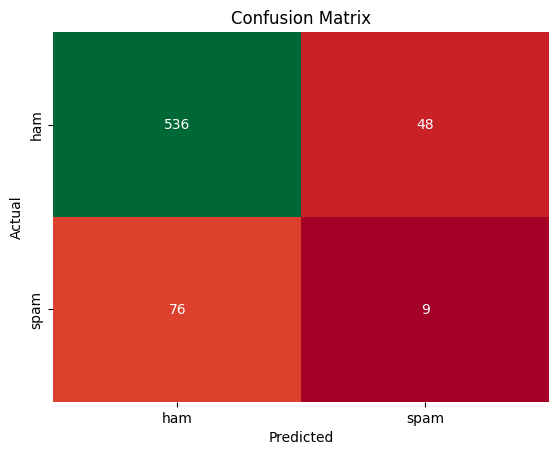

In [77]:
from sklearn.metrics import confusion_matrix

prediction = model.predict(X_valid)
cm = confusion_matrix(y_valid, prediction)

labels = np.unique(y_valid)
sns.heatmap(cm,annot=True,fmt='d',cmap='RdYlGn',cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [78]:
TN, FP, FN, TP = cm.ravel()
accuracy = (TN + TP) / (TN + FP + FN + TP)
print("Accuracy Score =", format(accuracy))

Accuracy Score = 0.8146487294469357


In [82]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = model.predict(X_valid)
y_true = y_valid
precision = precision_score(y_true, y_pred, pos_label='spam')
recall = recall_score(y_true, y_pred, pos_label='spam')
f1 = f1_score(y_true, y_pred, pos_label='spam')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.15789473684210525
Recall: 0.10588235294117647
F1 Score: 0.1267605633802817


In [83]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf=KFold(n_splits=5)
score=cross_val_score(model,X_train,y_train,cv=kf)
print(model)
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

BernoulliNB(alpha=0.1)
Cross Validation Scores are [0.98680739 0.98416887 0.97493404 0.97754293 0.97886394]
Average Cross Validation score :0.9804634318916149


In [86]:
pred_score = model.predict_proba(X_valid)[:, 1]

from sklearn.metrics import roc_curve

fpr,tpr,thresholds = roc_curve(y_valid,pred_score,pos_label='spam')

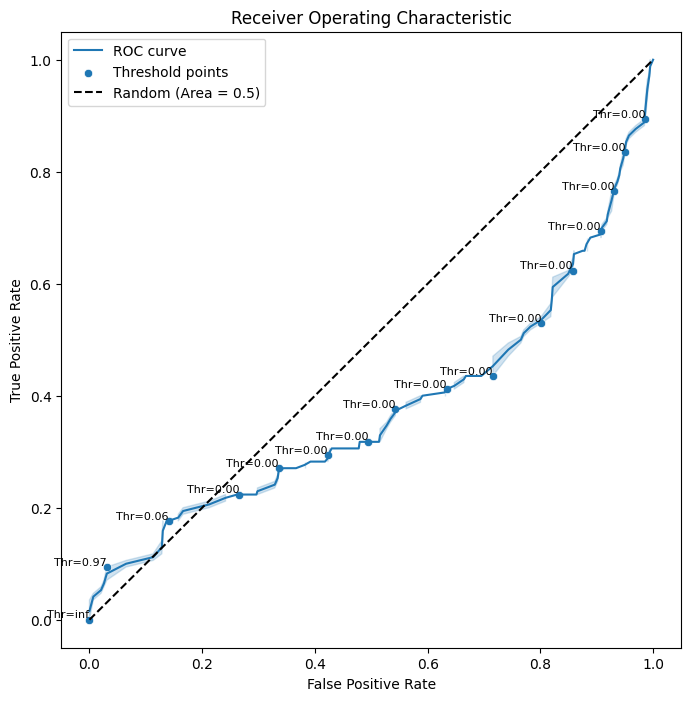

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame with the data
roc_data = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

# Plot ROC curve
plt.figure(figsize=(8, 8))
sns.lineplot(data=roc_data, x='fpr', y='tpr', label='ROC curve')

# Plot threshold points
n = 10
indices = np.arange(len(thresholds)) % n == 0
sns.scatterplot(data=roc_data[indices], x='fpr', y='tpr', label='Threshold points')

# Add text labels for threshold points
for index, row in roc_data[indices].iterrows():
    plt.text(row['fpr'], row['tpr'], f"Thr={row['thresholds']:.2f}", fontsize=8, ha='right', va='bottom')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random (Area = 0.5)')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

# Display legend
plt.legend()

# Show the plot
plt.show()

In [121]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold is:", optimal_threshold)

Optimal threshold is: 0.9736526375261405


<Axes: xlabel='Predicted', ylabel='Actual'>

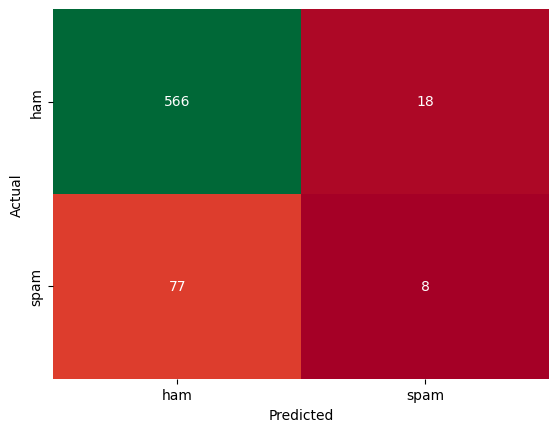

In [122]:

# Convert predicted probabilities to binary predictions using the optimal threshold
binary_predictions = (pred_score >= optimal_threshold).astype(int)
# Evaluate the performance with the optimal threshold
confusion_matrix = pd.crosstab(y_valid, binary_predictions, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix,annot=True,fmt='d',cmap='RdYlGn',cbar=False, xticklabels=labels, yticklabels=labels)